# <center>Residential Solar Panel Size Detection</center>

*The Nation that leads in renewable energy will be the nation that leads the world* —James Cameron 

21st century has encountered severe global environmental problem such as polar ice-century melting, regular earthquakes in south-east Asia and consequent tsunami. Scientists have connected them with global warming. Globally people have been more educated about need for clean energy. Sun is and will always remain the biggest source of energy. Solar power has been developed for a last couple of decades but common people has always hesitated to adopt it in a mass scale. There have been concerns regarding is it right for residential home, how many solar panel will replace the conventional energy sources etc.

Mass scale moving towards clean energy and better future will only happen when common people will adopt it in residential setting. Here I take a step towards demystifying how many solar panel we need to completely eliminate electricity bill. There a lot of factors that could be connected to efficient solar energy production and we will consider them over the project. Data for this project has been collected from [National Renewable Energy Laboratory](https://openpv.nrel.gov/search)

## ► <span  style="color:blue; font-size:15px"> **Objective:** Predict size of solar panels for residential setting</span>

Here is a video to learn how home solar panels work! 

[![How Home Solar Panel Works](http://img.youtube.com/vi/m6UgO6-HELc/0.jpg)](http://www.youtube.com/watch?v=m6UgO6-HELc) 

# Contents of the Notebook:

# 1. Exploratory Data Analysis (EDA)

## 1.A. Import libraries and load data

In [408]:
import numpy as np
import pandas as pd
import pandas_profiling as pf
from collections import Counter

# VisualiZation
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Configure visualisations
%matplotlib inline
plt.style.use('ggplot')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# 1.B. Load data 
We can have basic information of the columns and about data overall, stored in the form of a dictionary.

In [409]:
pd.options.display.max_colwidth = 100
solar_dictionary = pd.read_excel('solar_sizepred_datadict.xlsx', index_col='Column Names')
solar_dictionary

,Description
Column Names,
state,Which state the customer belongs
date_installed,How long ago it has been installed
incentive_prog_names,Incentive programs specific to the states
size_kw,Size of the solar panels installed (TARGET)
zipcode,customers zipcode
install_type,customers pupose of installation
installer,Installing company for solar panels
city,Which city customer belongs to
tech_1,Different types of solar panels that determins solar panel quality


Raw data from National Renewable Energy Laboratory was cleaned and features that consumers can not relate to are removed.

In [410]:
solar = pd.read_csv('solar_sizepred.csv', parse_dates=['date_installed']) 
solar.head()

,state,date_installed,incentive_prog_names,size_kw,zipcode,install_type,installer,city,tech_1,county,annual_PV_prod,annual_insolation,tracking_type
0,TX,2013-12-12,Austin Energy,10.56,78702,residential,NaN,AUSTIN,Poly,Travis,14999.831600,5.157692,Fixed
1,TX,2014-07-11,Austin Energy,12.72,78702,residential,NaN,AUSTIN,Mono,Travis,17811.574390,5.085633,Fixed
2,TX,2014-01-17,Austin Energy,5.40,78702,residential,NaN,AUSTIN,Mono,Travis,7833.742822,5.262714,Fixed
3,TX,2012-09-27,Austin Energy,7.50,78702,residential,NaN,AUSTIN,Poly,Travis,10151.709590,4.920972,Fixed
4,TX,2012-09-26,Austin Energy,5.00,78702,residential,NaN,AUSTIN,Poly,Travis,7307.133789,5.304778,Fixed


We will only select residential data and upto 40 Kw. Any bigger installation are generally anomaly based on research.

In [411]:
# Range of residential is upto 40kWh generally
filt1 = solar['install_type'] == 'residential'
filt2 = (solar['size_kw'] > 0) & (solar['size_kw'] < 40)
solar = solar[filt1 & filt2]

# All residential so drop column 'install_type'
solar = solar.drop(columns=['install_type'])
solar.shape

(487253, 12)

In [412]:
solar.isna().mean().round(2)

state                   0.00
date_installed          0.00
incentive_prog_names    0.00
size_kw                 0.00
zipcode                 0.00
installer               0.13
city                    0.00
tech_1                  0.22
county                  0.00
annual_PV_prod          0.00
annual_insolation       0.00
tracking_type           0.29
dtype: float64

Text(0.5,0.95,'Count of missing values')

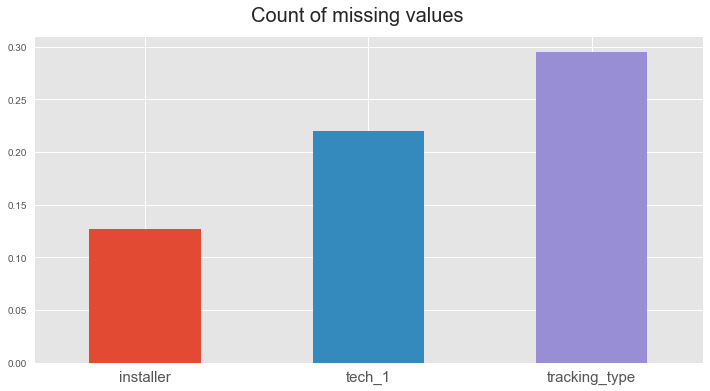

In [413]:
f,ax=plt.subplots(figsize=(12,6))
missing = solar.isna().mean()
missing[missing>0].plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=15)
f.suptitle('Count of missing values', fontsize=20, y=.95)

♦ **Initial observation:**
`installer`, `tech_1`, and `tracking_type` columns contain missing values. Here we will replace them with `Unknown`

In [414]:
solar['installer'].fillna("Unknown", inplace=True)
solar['tech_1'].fillna("Unknown", inplace=True)
solar['tracking_type'].fillna("Unknown", inplace=True)

In [415]:
solar.isna().sum()

state                   0
date_installed          0
incentive_prog_names    0
size_kw                 0
zipcode                 0
installer               0
city                    0
tech_1                  0
county                  0
annual_PV_prod          0
annual_insolation       0
tracking_type           0
dtype: int64

# 1.C. Feature Engineering

In [416]:
# Zipcode: extract initial numbers of zipcode to see impact on energy production if area is classified largely
solar['zipcode_1'] = solar['zipcode'].astype('str').str[:1].astype(int)
solar['zipcode_2'] = solar['zipcode'].astype('str').str[:2].astype(int)
solar['zipcode_3'] = solar['zipcode'].astype('str').str[:3].astype(int)

# DateTime column: extract year and month of installation
date = solar['date_installed']
solar['year'] =  date.dt.year
solar['month'] = date.dt.month
solar_x = solar.copy()

# Divide data into train and test
solar_train, solar_test = train_test_split(solar, test_size=0.2)
solar = solar_train
solar.dtypes

state                           object
date_installed          datetime64[ns]
incentive_prog_names            object
size_kw                        float64
zipcode                          int64
installer                       object
city                            object
tech_1                          object
county                          object
annual_PV_prod                 float64
annual_insolation              float64
tracking_type                   object
zipcode_1                        int32
zipcode_2                        int32
zipcode_3                        int32
year                             int64
month                            int64
dtype: object

In [417]:
# We are focusing on data after 2000
#solar = solar[solar['year'] > 1999]
#solar.shape

► Uniques values in some categorical columns such as `installer`, `city`, `county` etc are large. We will only retain the categories in a categorical column that has 1% or more appearances. Rest categories of that column will be aggregated as `Others`. This will be done for both train and test set.

In [418]:
solar.describe(include=['O']).T

,count,unique,top,freq
state,389802,19,CA,209292
incentive_prog_names,389802,47,California Public Utilities Commission (California Solar Initiative),112646
installer,389802,5935,SolarCity,90506
city,389802,7578,TUCSON,7686
tech_1,389802,12,Poly,175945
county,389802,481,Los Angeles,37323
tracking_type,389802,5,Fixed,274027


In [419]:
def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    # reduced list is name of categorical columns
    
    patterns = []
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    other = []
    
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        norm_list = df_normalized[filt]['col_name'].tolist()
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold
        
        pattern = norm_list
        patterns.append(norm_list)
        
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        
        else:
            df.drop(col, inplace=True, axis=1)
    
    return (df, patterns, reduced_list, other)

df, patterns, reduced_list, other = group_levels_in_categoricals(solar)

# solar training set after transformation
solar.describe(include=['O']).T

,count,unique,top,freq
state,389802,12,CA,209292
incentive_prog_names,389802,18,California Public Utilities Commission (California Solar Initiative),112646
installer,389802,12,Other,179301
city,389802,7,Other,354919
tech_1,389802,5,Poly,175945
county,389802,22,Other,129747
tracking_type,389802,3,Fixed,274027


In [420]:
# We have to keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):
    
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)
            
    return df_test

df_test = group_levels_in_categoricals_test(reduced_list, other, patterns, solar_test)

# solar test set after transformation
solar_test.describe(include=['O']).T

,count,unique,top,freq
state,97451,12,CA,52581
incentive_prog_names,97451,18,California Public Utilities Commission (California Solar Initiative),28174
installer,97451,12,Others,44833
city,97451,7,Others,88751
tech_1,97451,5,Poly,43890
county,97451,22,Others,32213
tracking_type,97451,3,Fixed,68367


♦ Solar train and test set categorical columns has same number of unique values

In [421]:
# Overall summary of the dataset
pf.ProfileReport(solar)

Number of variables,18
Number of observations,389802
Total Missing (%),0.0%
Total size in memory,49.1 MiB
Average record size in memory,132.0 B
Numeric,6
Categorical,7
Boolean,0
Date,1
Text (Unique),0
Rejected,4


# 2.A. Explore target variable: `size_kw`

mu = 6.18 and sigma = 3.27



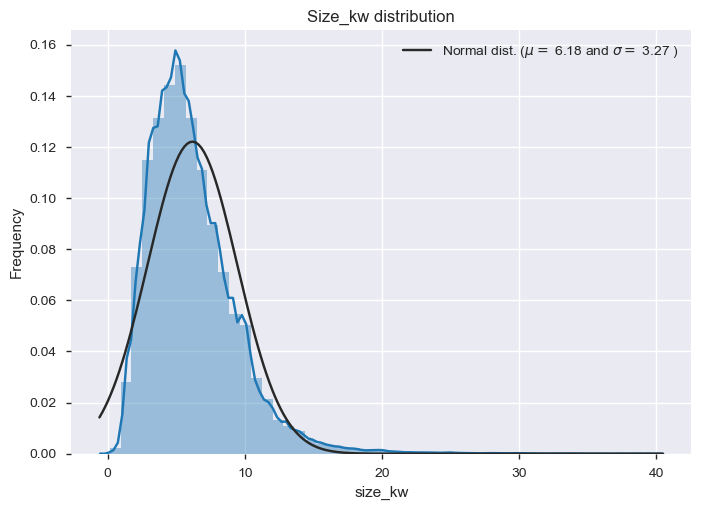

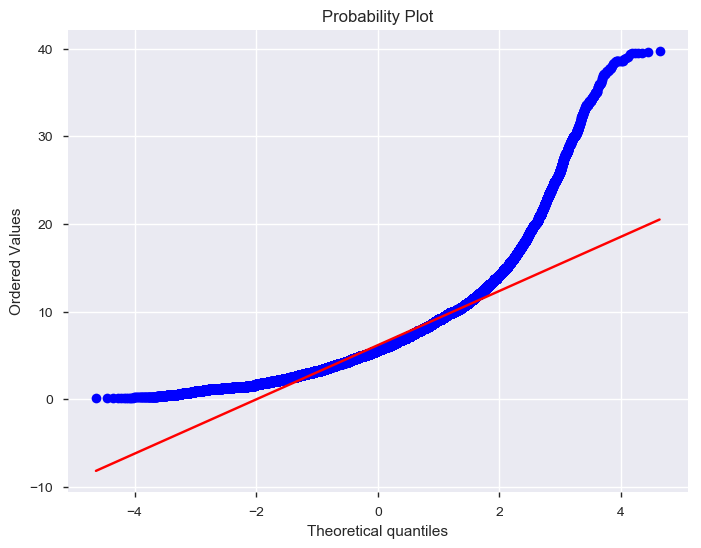

Skewness: 1.744709
Kurtosis: 7.022592


In [422]:
import scipy.stats as st
from scipy.stats import norm, skew # for some statistics

sns.distplot(solar['size_kw'], fit=norm)
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(solar['size_kw'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Size_kw distribution')

# Get also the QQ-plot
fig = plt.figure(figsize=(8,6))
res = st.probplot(solar['size_kw'], plot=plt)
plt.show()

print("Skewness: %f" % solar['size_kw'].skew())
print("Kurtosis: %f" % solar['size_kw'].kurt())

→ Target variable is clearly right skewed. So we have to transform target variable before running regression

→ Below we see Johnson distribution and log transformation fits our target pretty well

Text(0.5,1,'Log Normal')

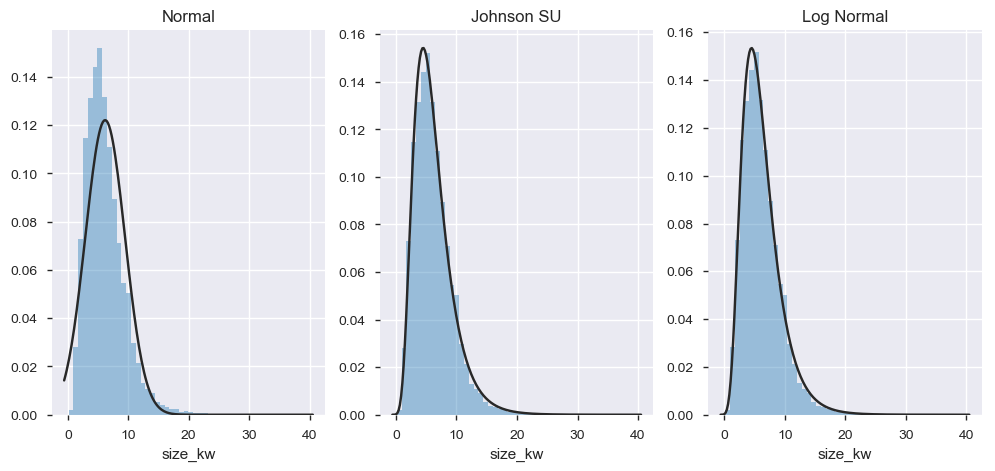

In [423]:
fig, axes = plt.subplots(1,3, figsize = (12,5))

sns.distplot(solar['size_kw'], kde=False, fit=st.norm, ax=axes[0])
axes[0].set_title('Normal')

sns.distplot(solar['size_kw'], kde=False, fit=st.johnsonsu, ax=axes[1])
axes[1].set_title('Johnson SU')

sns.distplot(solar['size_kw'], kde=False, fit=st.lognorm, ax=axes[2])
axes[2].set_title('Log Normal')


 mu = 1.88 and sigma = 0.43



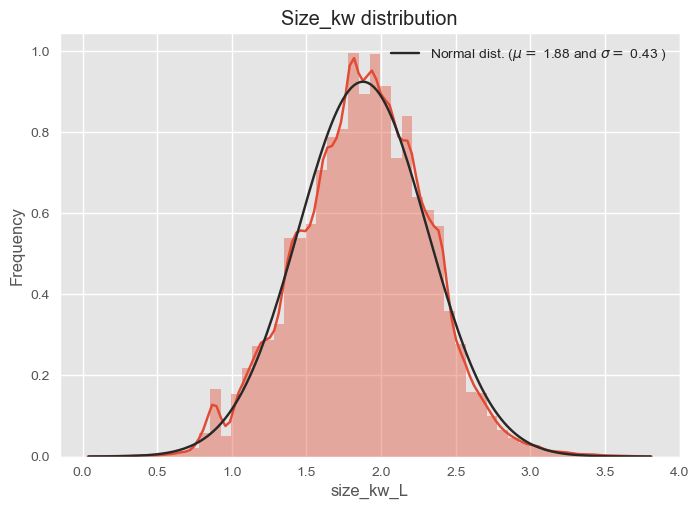

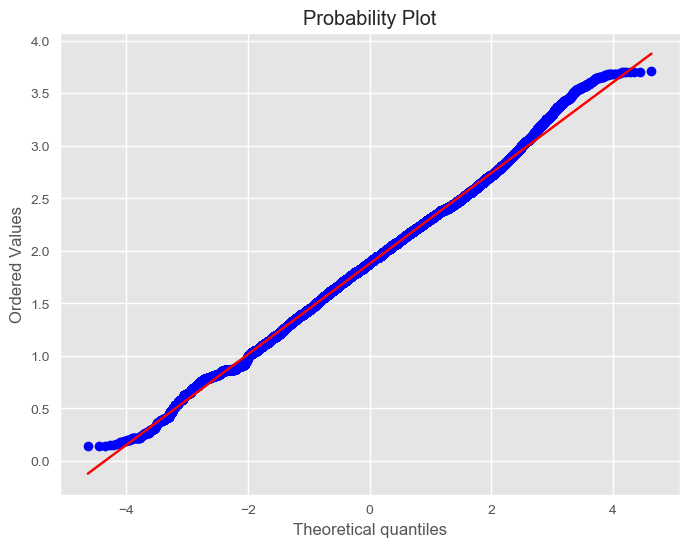

Skewness: -0.038406
Kurtosis: 0.124188


In [495]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
solar['size_kw_L'] = np.log1p(solar['size_kw'])

#Check the new distribution 
sns.distplot(solar['size_kw_L'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(solar['size_kw_L'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Size_kw distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(8,6))
res = stats.probplot(solar['size_kw_L'], plot=plt)
plt.show()

print("Skewness: %f" % solar['size_kw_L'].skew())
print("Kurtosis: %f" % solar['size_kw_L'].kurt())

→ After log transformation, target variable follow normal distribution.

# 2.B. Column-wise relationship

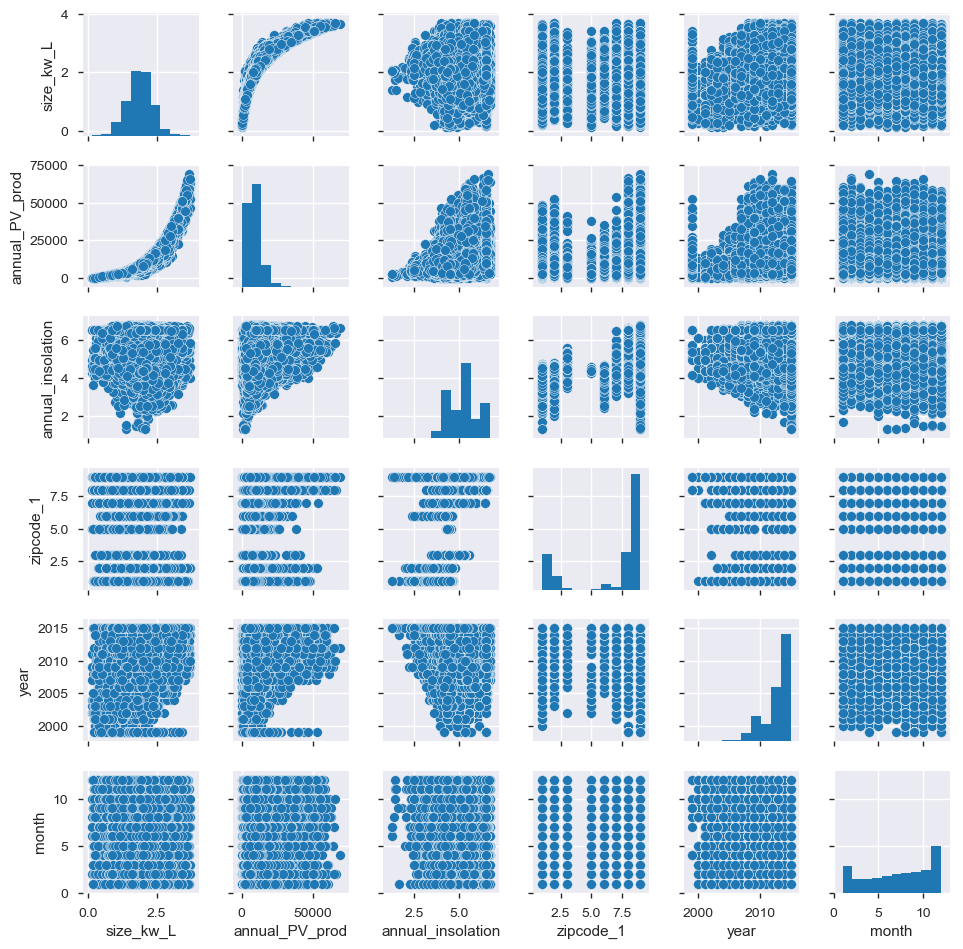

In [425]:
# Overall columns
cols = ['state','incentive_prog_names', 'size_kw_L','installer', 'city', 'tech_1', 'county', 'annual_PV_prod',
       'annual_insolation', 'tracking_type', 'zipcode_1', 'year', 'month']
sns.pairplot(solar[cols], size = 1.6)
plt.show()

♦ **Initial observation:** <br>
→ As expected `size_kw` and `annual_PV_prod` are highly correlated <br>
→ In the same line, higher insolation (amount of solar radiation reaching an area) ensures more `annual_PV_prod`. Varied range of energy production at higher insolation might be because of differences in size of solar panels installed.

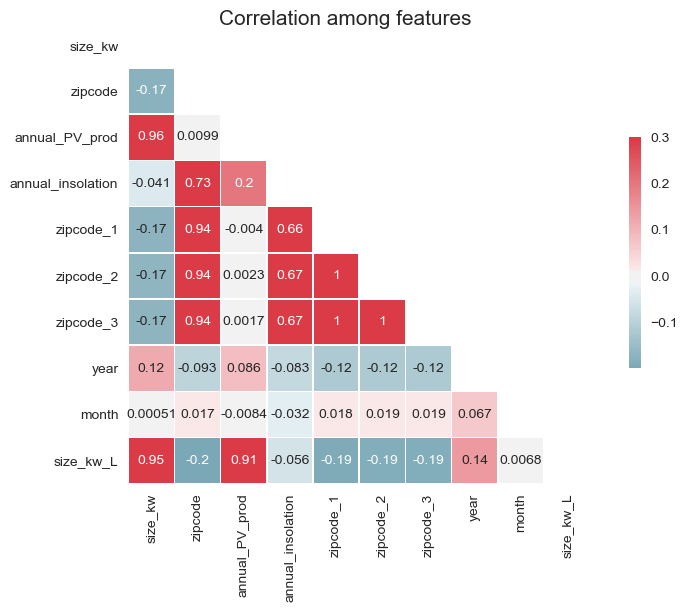

In [426]:
# EDA: Correlation matrix among all features will inform us relationship between features
sns.set(style='white', font_scale = 1)

# Correlation matrix
corr = solar.corr()
# Generate mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up matplotlib figure
f,ax = plt.subplots(figsize= (10,6))
f.suptitle('Correlation among features', x=0.5, y=.9, fontsize = 15)

# Generate custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, annot_kws={'size': 10}, mask=mask, cmap=cmap, vmax=.3, 
                                    center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5})

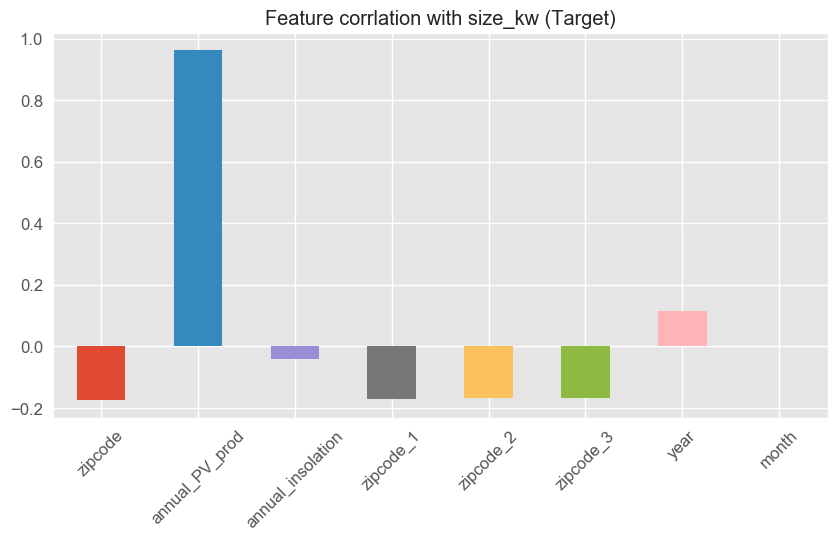

In [494]:
# EDA: Correlation with target
solar2 = solar.drop(columns=['size_kw', 'size_kw_L', 'annual_PV_prod_L'])
solar2.corrwith(solar['size_kw']).plot.bar(figsize=(10,5),
                                               title = 'Feature corrlation with size_kw (Target)',
                                               fontsize = 12, rot = 45)
plt.style.use('ggplot')

♦ **Initial observation:** <br>
→ As expected, size of solar panels are strongly correlated with annual energy production  <br>
→ Annual insolation is also strongly correlated with zipcode (as zipcode or location and amount of solar radiation falling on a particular area are dependent on each other).

# 2.C. Analysis of individual features

## Types Of Features
The 2 broad classes of variables in the dataset are categorical and continuous.

### Categorical Features:
A categorical variable is one that is limited to finite number of categories. Categories can be labels or discrete numerical values. For example, gender is a categorical variable having two categories (male and female). Categorical features can be further divided into nominal and ordinal data.

• **Ordinal data** has a natural ordering but the difference between the orders is not measurable. For example, cancer stage 4 is worse than stage 3 (an order), but we can not quantify how much worse. <br>
• **Nominal data** are the categorical data without any natural ordering. For example, all available hair color dyes.<br>
► Categorical Features in the dataset are updated in the data dictionary below.
### Continuous Feature:
A continuous variable can take an infinite set of numerical values. <br>
► Continuous Features in the dataset are updated in the data dictionary below.

In [428]:
# select features with <20 unique elements as categories 
solar.nunique()

state                       12
date_installed            4445
incentive_prog_names        18
size_kw                  16825
zipcode                   7561
installer                   12
city                         7
tech_1                       5
county                      22
annual_PV_prod          244252
annual_insolation        61533
tracking_type                3
zipcode_1                    8
zipcode_2                   71
zipcode_3                  522
year                        17
month                       12
size_kw_L                16825
dtype: int64

In [429]:
# update data dictionary about feature type
solar_dictionary.drop(solar_dictionary.index[5:6], inplace=True)
solar_dictionary.loc['month']= 'month of installation'
solar_dictionary.loc['year']= 'year of installation'
solar_dictionary.loc['zipcode_1']= '1st number of zipcode'
solar_dictionary.loc['zipcode_2']= 'First 2 number of zipcode'
solar_dictionary.loc['zipcode_3']= 'First 3 number of zipcode'

c, o, n, d = 'continuous', 'ordinal', 'nominal', 'datetime'
d = {'size_kw':c, 'annual_PV_prod':c, 'annual_insolation':c, 'zipcode':o, 'zipcode_1':o, 'zipcode_2':o,
     'zipcode_3':o, 'year':o, 'month':o, 'tech_1':o, 'date_installed': d, 'state': n, 'city': n, 'county': n,
    'incentive_prog_names': n, 'installer': n, 'tracking_type':n}
solar_dictionary['Feature Info'] = pd.Series(d)
solar_dictionary

,Description,Feature Info
Column Names,,
state,Which state the customer belongs,nominal
date_installed,How long ago it has been installed,datetime
incentive_prog_names,Incentive programs specific to the states,nominal
size_kw,Size of the solar panels installed (TARGET),continuous
zipcode,customers zipcode,ordinal
installer,Installing company for solar panels,nominal
city,Which city customer belongs to,nominal
tech_1,Different types of solar panels that determins solar panel quality,ordinal
county,Customers county,nominal


# 2.D. Analyzing numerical features

In [430]:
# Select numerical columns
solar_num = solar.select_dtypes(include=['number'])
solar_num.drop(columns = ['zipcode', 'zipcode_3'], inplace=True)
solar_num.head()

,size_kw,annual_PV_prod,annual_insolation,zipcode_1,zipcode_2,year,month,size_kw_L
383194,5.250,7289.098206,5.111246,9,93,2013,12,1.832581
100589,7.395,8793.513477,4.094448,1,10,2015,9,2.127636
371508,3.220,4989.500845,5.572553,9,92,2014,1,1.439835
269579,6.240,8882.655996,5.171541,7,78,2014,3,1.979621
34922,7.420,8878.289048,4.104475,1,14,2015,12,2.130610


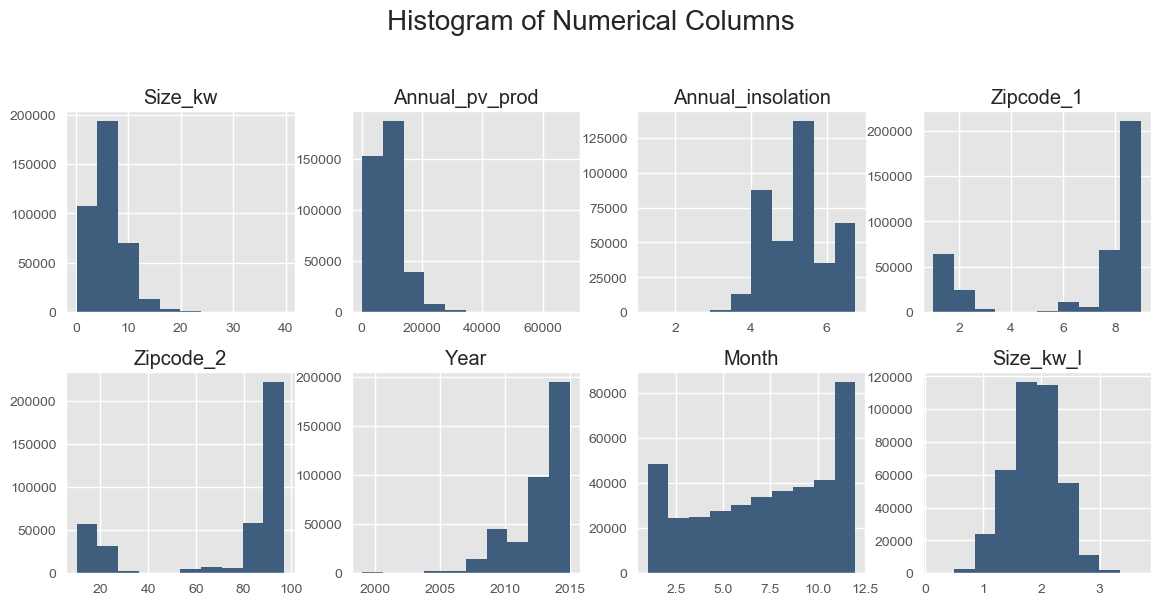

In [431]:
# EDA: Distribution of individual numerical features
fig, axes = plt.subplots(2,4, figsize=(14,6), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
axes = axes.ravel()
st = fig.suptitle('Histogram of Numerical Columns', fontsize = 20)
st.set_y(1.05)

for i in range(1, solar_num.shape[1]+1):
    vals = np.size(solar_num.iloc[:, i-1].unique())
    axes[i-1].hist(solar_num.iloc[:, i-1],color = '#3F5D7D')
    axes[i-1].set_title(solar_num.columns[i-1].capitalize())

fig.tight_layout()

♦ **Initial observation:** <br>
→ `size_kw` follows normal distribution once it is log transformed. <br>
→ `Annual_insolation` and `annual_PV_prod` are not normally distributed <br>
→ Most installations have happened with areas with `zipcode` starting with `9` <br>
→ Most installations have happened in recent times <br>
→ Installations are relatively higher in December and January

## `annual_PV_prod`: Annual photovoltaic energy production

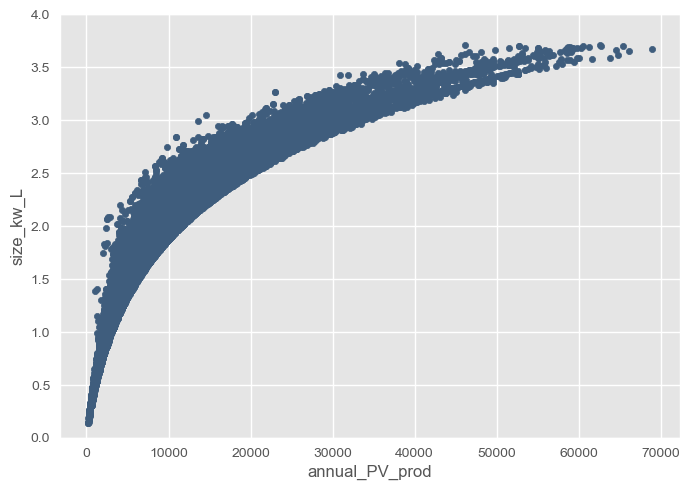

In [432]:
solar.plot.scatter(x='annual_PV_prod', y='size_kw_L', ylim=(0,4), color = '#3F5D7D')

♦ **Initial observation:** <br>
→ Initial exploration suggests `size_kw` and `annual_PV_prod` are strongly correlated, and thus most likely an important predictor.

mu = 9059.82 and sigma = 4943.71


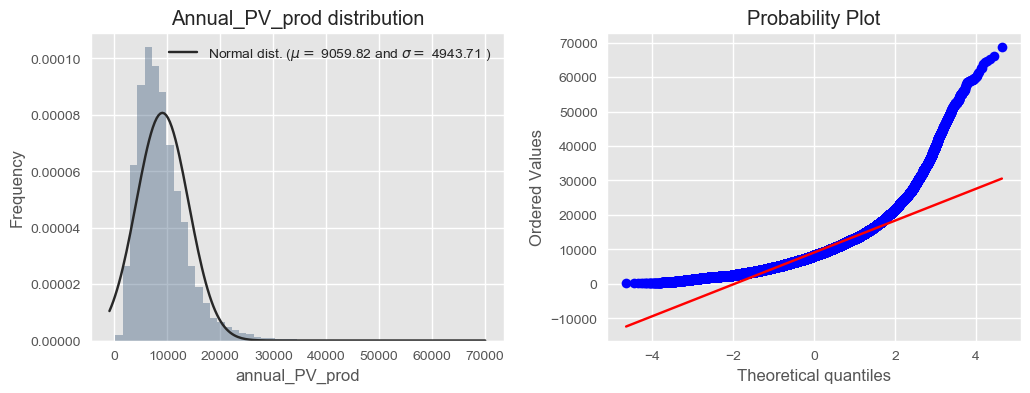

Skewness: 1.921484
Kurtosis: 8.082814


In [433]:
fig, axes = plt.subplots(1,2, figsize=(12, 4), gridspec_kw = {'wspace':0.25, 'hspace':0.30})

sns.distplot(solar['annual_PV_prod'], kde=False, fit=norm, ax=axes[0], color = '#3F5D7D')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(solar['annual_PV_prod'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
axes[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Annual_PV_prod distribution')

#Get also the QQ-plot
res = stats.probplot(solar['annual_PV_prod'], plot=plt)
plt.show()

print("Skewness: %f" % solar['annual_PV_prod'].skew())
print("Kurtosis: %f" % solar['annual_PV_prod'].kurt())

→ `annual_PV_prod` variable is clearly right skewed. So we have to transform it similar to target variable before running regression.

→ Below we observe log transformation of `annual_PV_prod` allowed it to follow normal distribution. 

mu = 8.98 and sigma = 0.53


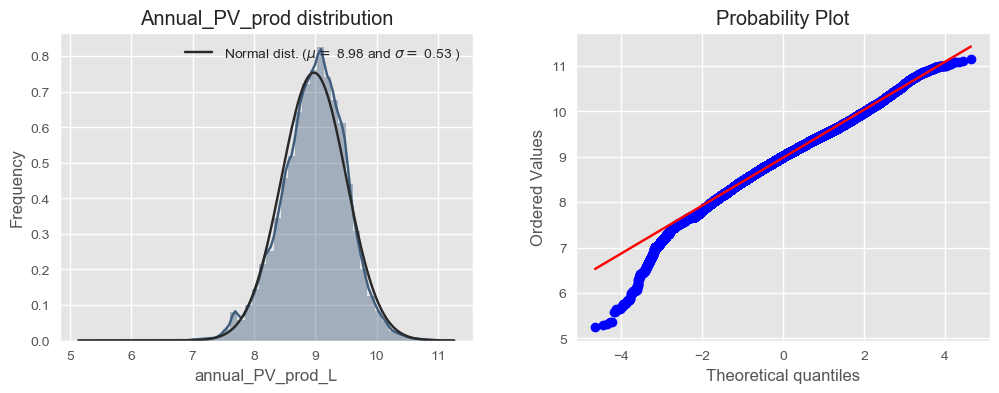

Skewness: -0.281333
Kurtosis: 0.572694


In [436]:
fig, axes = plt.subplots(1,2, figsize=(12,4), gridspec_kw = {'wspace':0.25, 'hspace':0.30})

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
solar['annual_PV_prod_L'] = np.log1p(solar['annual_PV_prod'])

#Check the new distribution 
sns.distplot(solar['annual_PV_prod_L'], fit=norm, ax=axes[0], color = '#3F5D7D')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(solar['annual_PV_prod_L'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
axes[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Annual_PV_prod distribution')

#Get also the QQ-plot
res = stats.probplot(solar['annual_PV_prod_L'], plot=plt)
plt.show()

print("Skewness: %f" % solar['annual_PV_prod_L'].skew())
print("Kurtosis: %f" % solar['annual_PV_prod_L'].kurt())

## `annual_insolation`: Amount of solar radiation falling on a particular area

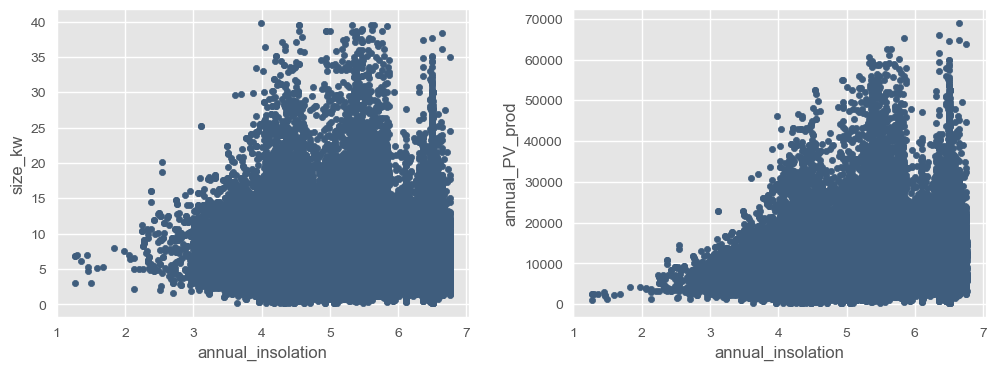

In [442]:
f, ax = plt.subplots(1,2, figsize=(12,4), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
solar.plot.scatter(x='annual_insolation', y='size_kw', ax=ax[0], color = '#3F5D7D')
solar.plot.scatter(x='annual_insolation', y='annual_PV_prod', ax=ax[1], color = '#3F5D7D')

♦ **Initial observation:** <br>

→ Insolation's relation with `size_kw` is not clear from the data (because size of solar panel installed although can be dependent on solar radiation on a particular area, it is more likely to be based on the energy consumption in that particular household). <br>

→ As expected with increase in `annual_insolation`, `annual_PV_prod` increases. So to produce the same amount of energy, area with higher insolation will need to install less `size_kw` and vice versa. However, we see a large range of amount of energy production at higher insolation. This might be due to how many solar panels are installed, quality of solar panel efficiency in production energy etc

# 2.E. Analyzing categorical features

## `year`: year of installation of solar panels

In [443]:
solar.pivot_table(index='year', columns='month', values='size_kw', 
                               fill_value=0, aggfunc='size').style.background_gradient(cmap='summer_r')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1999,0,0,0,5,0,0,1,1,778,1,0,8
2000,7,3,4,2,4,0,0,4,1,1,2,3
2001,6,13,10,15,13,10,19,12,12,20,18,14
2002,23,21,33,25,25,26,31,54,51,76,53,57
2003,45,29,24,25,17,40,28,29,40,47,37,44
2004,48,31,31,49,53,43,67,72,62,57,72,61
2005,86,53,87,61,73,116,111,113,127,107,126,194
2006,137,110,146,146,174,175,166,200,163,186,173,175
2007,114,115,155,190,272,376,424,556,622,694,712,713


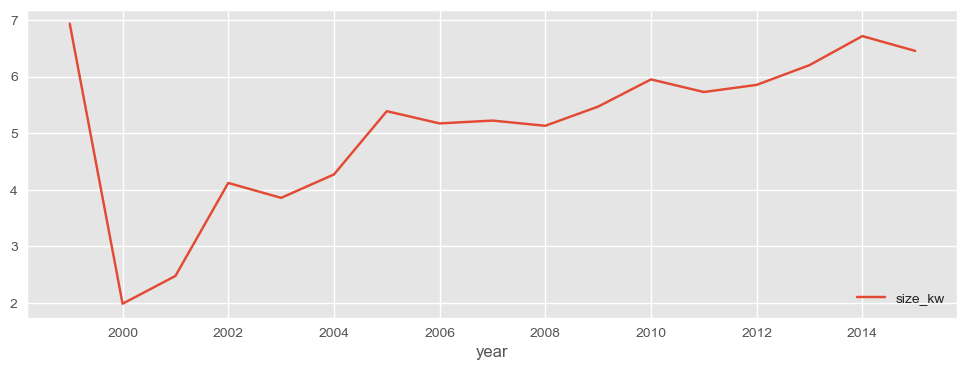

In [444]:
f,ax = plt.subplots(figsize=(12,4))
solar_year = solar.groupby('year').agg({'size_kw':'mean'})
solar_year.plot(ax=ax)

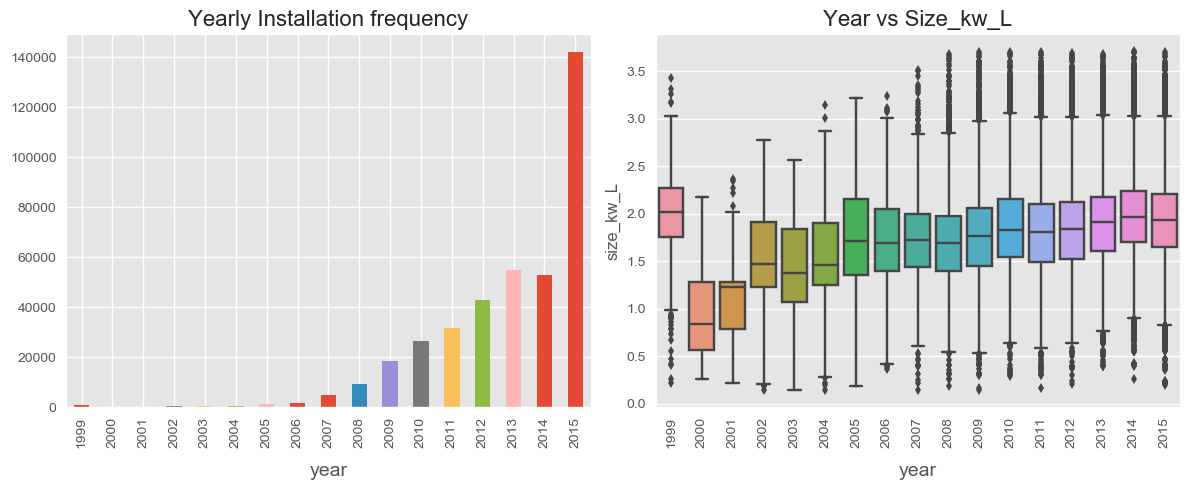

In [459]:
def value_count_plot(data, col, sort, ascending, ax, xlabel, title, size, fontsize, font, rotation=0):
    data[col].value_counts(sort=sort).plot.bar(ax=ax)
    ax.set_xlabel(xlabel, fontsize = font, labelpad = 10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize, rotation = rotation)
    ax.set_title(title, size=size)
    
def cat_box_plot(x, y, data, ax, xlabel, title, size, fontsize, font, rotation=0):
    sns.boxplot(x, y, data=data, ax=ax)
    ax.set_title(title, size=size)
    ax.set_xlabel(xlabel, fontsize = font, labelpad = 10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize, rotation = rotation)
    plt.tight_layout()
    plt.show()
    
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='year', sort=False, ascending=False, ax=ax[0], 
                 xlabel='year', title='Yearly Installation frequency', size= 16, fontsize=10, font=14, rotation=90)


cat_box_plot(x= 'year', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='year', 
                     title='Year vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Overall, number of installations have increased over the years <br>

→ Size of the installations have also increased from the initial years (except 1999). 

# `month`: installation month of solar panels

In [447]:
solar.pivot_table(index='month', columns='state', values='size_kw', aggfunc='size').style.background_gradient(cmap='summer_r')

state,AZ,CA,CT,MA,MD,NJ,NM,NV,NY,Other,PA,TX
month,,,,,,,,,,,,
1,3771,13754,731,2317,356,450,184,673,2316,430,491,324
2,3408,11845,572,2171,284,299,248,550,2088,432,283,306
3,3686,12236,702,2778,336,387,273,497,2403,502,285,282
4,3565,12300,733,3328,393,450,268,482,2397,575,334,301
5,3877,13819,694,3740,417,385,274,853,2266,582,393,279
6,3885,15751,901,3881,435,529,328,712,2251,818,431,333
7,4017,18965,934,4411,458,478,323,759,1954,721,429,375
8,4095,20678,1007,4327,445,472,369,1091,2481,609,471,404
9,4863,20509,1141,4902,439,449,354,955,2755,786,405,536


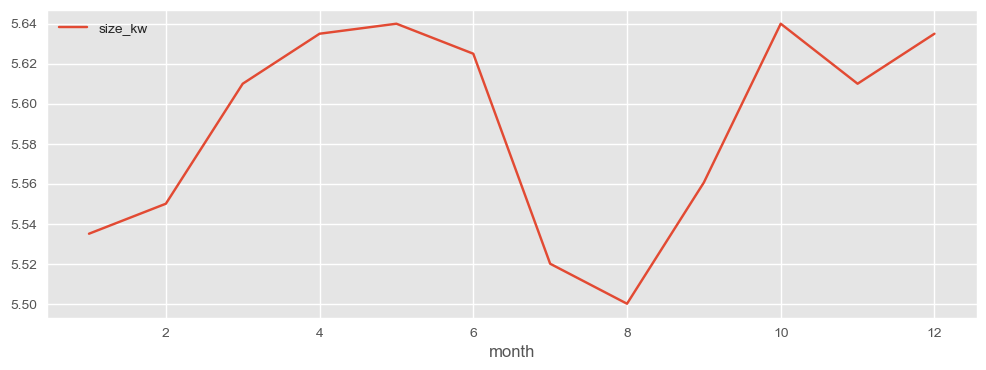

In [451]:
f,ax = plt.subplots(figsize=(12,4))
solar_year = solar.groupby('month').agg({'size_kw':'median'})
solar_year.plot(ax=ax)

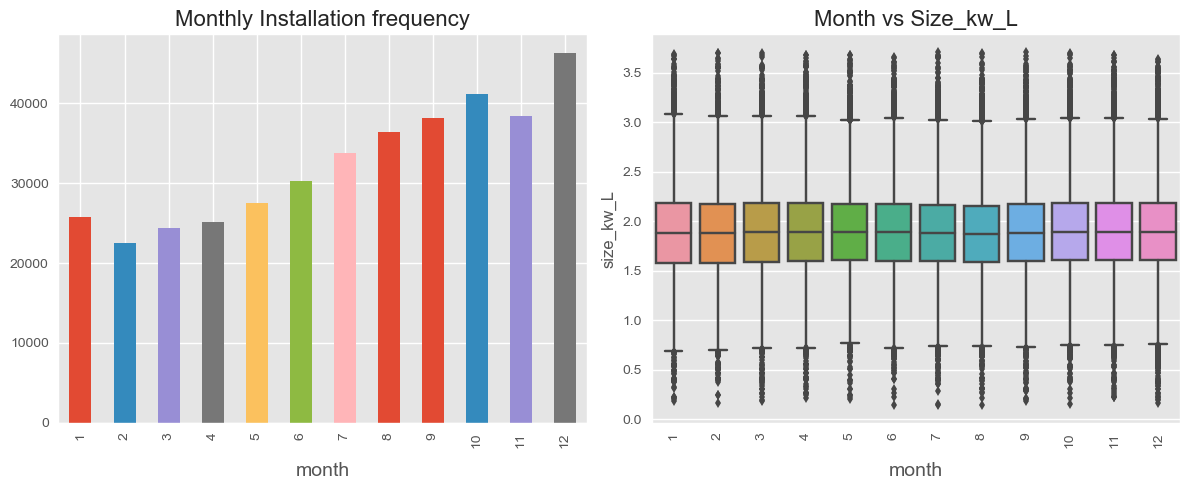

In [458]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='month', sort=False, ascending=False, ax=ax[0], 
                 xlabel='month', title='Monthly Installation frequency', size= 16, fontsize=10, font=14, rotation=90)


cat_box_plot(x= 'month', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='month', 
                     title='Month vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Number of installations are generally higher during December <br>

→ Which month solar panels are installed have no impact on size of solar panels installed.

→ When we explore state-wise installation,  MA, MD and NJ show a different trend that rest of the other states in number of solar panel installations over different months

# `state`

In [456]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

df.pivot_table(index='year', columns='state', values='size_kw', aggfunc='size', 
                               fill_value=0).style.apply(highlight_max)

state,AZ,CA,CT,MA,MD,NJ,NM,NV,NY,Other,PA,TX
year,,,,,,,,,,,,
1999,778,9,0,0,0,0,0,0,0,7,0,0
2000,5,4,0,0,0,0,0,0,1,21,0,0
2001,0,114,0,0,0,2,0,0,8,36,0,2
2002,16,238,0,0,0,21,0,0,150,43,7,0
2003,52,52,0,44,0,56,0,0,128,51,22,0
2004,68,36,0,79,0,193,0,5,155,56,15,39
2005,137,106,26,43,16,509,0,40,153,49,70,105
2006,291,220,62,146,29,588,0,53,326,126,4,106
2007,283,3145,143,141,0,439,0,78,491,97,4,122


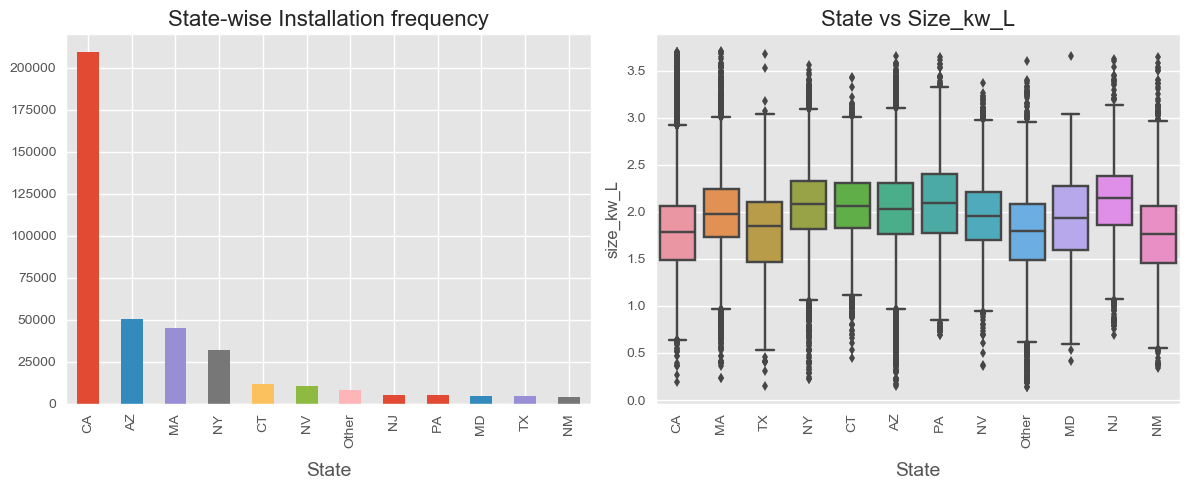

In [457]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='state', sort=True, ascending=False, ax=ax[0], 
                 xlabel='State', title='State-wise Installation frequency', size= 16, fontsize=10, font=14, rotation=90)


cat_box_plot(x= 'state', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='State vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Overall, number of installations and size of installation have increased over the years in different states  <br>

→ Although CA has maximum amount of installations, the mean size of solar panel installation in CA is less the most of the states

## `zipcode_1`: 1st number from zipcode representing a larger area

In [461]:
solar.groupby('zipcode_1').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

In [462]:
df.pivot_table(index='zipcode_1', columns='year', values='size_kw', 
                       fill_value=0, aggfunc='size').style.apply(highlight_max)

year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
zipcode_1,,,,,,,,,,,,,,,,,
1,0,1,8,158,164,204,250,444,626,856,1789,3866,3839,4004,6488,13185,28315
2,0,0,0,0,32,47,33,87,59,221,755,691,1024,2057,2978,5241,11443
3,0,0,0,1,0,0,0,10,14,49,533,533,122,199,223,401,913
5,0,0,0,13,19,41,33,70,8,74,127,0,39,126,103,203,227
6,0,0,0,0,0,0,26,62,143,211,367,359,297,482,986,2492,5974
7,0,0,4,9,18,114,281,330,280,337,474,696,638,570,620,663,867
8,778,5,0,28,90,191,510,708,642,853,2783,5260,5747,7965,9666,11446,22049
9,16,25,150,266,82,49,121,240,3171,6944,11843,15037,19915,27640,33705,19368,72263


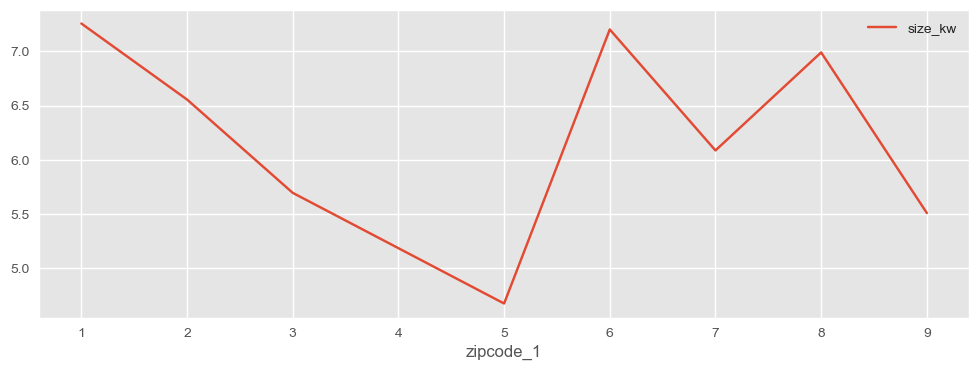

In [464]:
f,ax = plt.subplots(figsize=(12,4))
solar_year = solar.groupby('zipcode_1').agg({'size_kw':'mean'})
solar_year.plot(ax=ax)

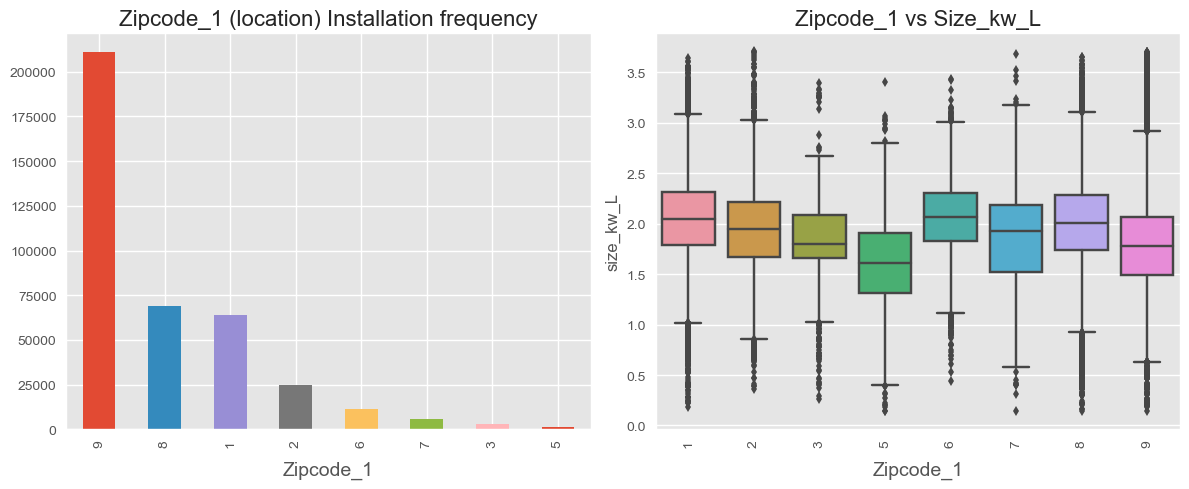

In [468]:
f,ax = plt.subplots(1,2,figsize=(12,5))

value_count_plot(data=solar, col='zipcode_1', sort=True, ascending=False, ax=ax[0], 
                 xlabel='Zipcode_1', title='Zipcode_1 (location) Installation frequency',size=16, fontsize=10, font=14, rotation=90)

cat_box_plot(x='zipcode_1', y='size_kw_L',data=solar, ax=ax[1], xlabel='Zipcode_1', 
                     title='Zipcode_1 vs Size_kw_L',size=16,fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Overall, area with 1st number of zipcode 9, has installed most solar panels over the years <br>

→ Size of the solar panels installed are least with area with zipcode starting with 5 

# `Installer`: installing company for solar panels

In [469]:
solar.groupby('installer').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

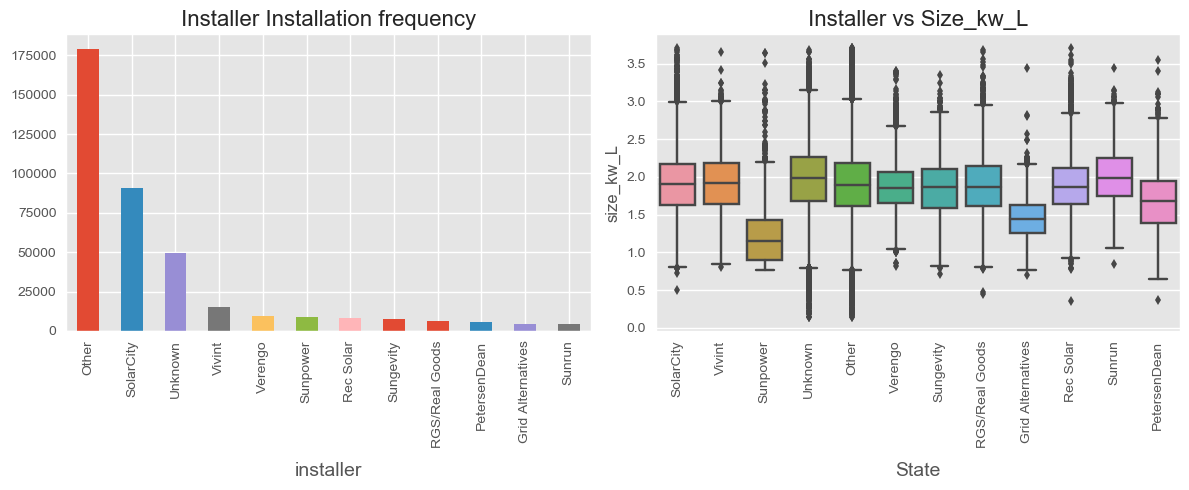

In [470]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='installer', sort=True, ascending=False, ax=ax[0], 
                 xlabel='installer', title='Installer Installation frequency', size= 16, fontsize=10, font=14, rotation=90)


cat_box_plot(x= 'installer', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='Installer vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ There were several companies over all these states who are officially registered to install solar panels. But the installation comapnies that have installed less than 1% of total solar panels, are aggregated as `others`.   <br>

→ Maximum size solar panels are installed by a company `Sunrun`. Maximum number of installations are done by `Solarcity`

# `Tech_1`: different types of solar panels 

In [471]:
solar.groupby('tech_1').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

In [472]:
df.pivot_table(index='tech_1', columns='year', values='size_kw', 
                       fill_value=0, aggfunc='size').style.apply(highlight_max)

year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
tech_1,,,,,,,,,,,,,,,,,
Mono,2,0,2,0,1,49,86,152,1209,3007,6287,10765,13271,17888,17542,12223,36511
Other,0,0,0,0,0,2,46,57,325,558,1286,966,559,232,92,29,459
Poly,0,0,1,7,25,89,165,407,1900,4083,7370,9628,11641,17797,29295,23906,69631
Unknown,792,31,159,467,379,506,955,1334,1501,1896,3696,4958,5855,6885,7564,15998,32635
crystalline,0,0,0,1,0,0,2,1,8,1,32,125,295,241,276,843,2815


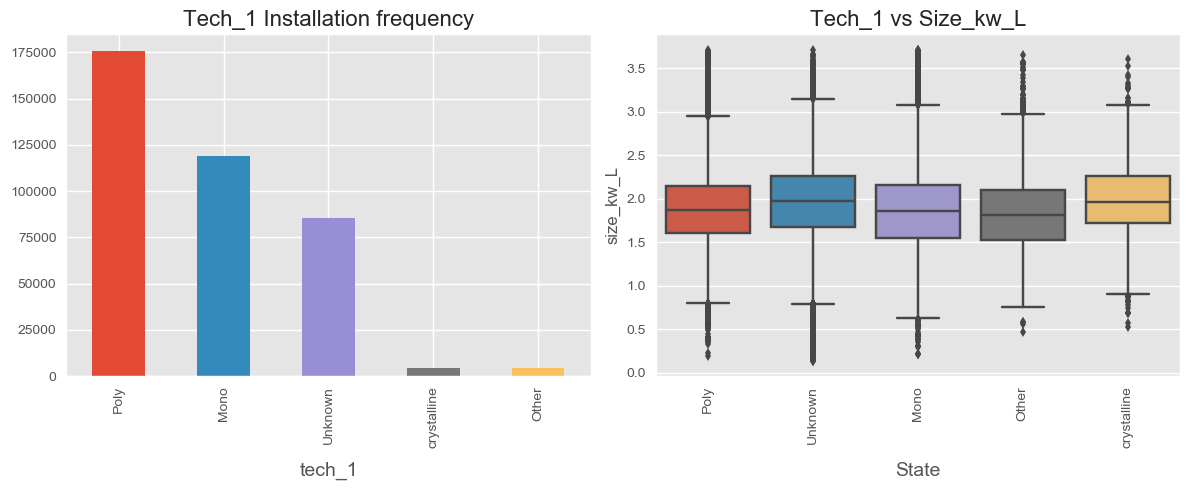

In [474]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='tech_1', sort=True, ascending=False, ax=ax[0], 
                 xlabel='tech_1', title='Tech_1 Installation frequency', size= 16, fontsize=10, font=14, rotation=90)


cat_box_plot(x= 'tech_1', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='Tech_1 vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Most popular solar panels used for residential setting is `Poly`  <br>

# `county` county where solar panel has been installed

In [475]:
pd.options.display.max_columns = 25
solar.groupby('county').agg({'size_kw':['mean', 'median', 'size']}).round(2).style.background_gradient(cmap='summer_r')

In [476]:
df.pivot_table(index='county', columns='year', values='size_kw', aggfunc='mean', 
                               fill_value=0).style.background_gradient(cmap='summer_r')

year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
county,,,,,,,,,,,,,,,,,
Alameda,2.268,0,0,0,0,0,0,0,4.00383,4.02478,4.55809,4.83585,5.01224,4.52437,4.94108,4.35037,4.26528
Bristol,0,0,0,0,0,5.07225,3.96,3.105,2.76,4.95667,4.36712,6.57429,6.16606,7.26076,6.90475,7.17871,7.27946
Clark,0,0,0,0,0,3.17333,4.33329,5.69295,5.49016,5.34571,5.5772,7.56507,7.92733,7.61979,7.60907,6.4749,6.83933
Contra Costa,0,0,0,0,0,0,0,1.8648,4.74098,4.25659,4.97261,5.51796,5.47781,5.31586,5.69094,5.20552,5.31517
Essex,0,0,0,2.26,4.38833,4.30929,5.26071,5.3747,3.19872,4.56323,4.77656,5.27699,6.65384,6.01171,5.83636,6.62993,6.88327
Fresno,0,0,0,0,0,0,0,0,5.96778,5.51055,6.23998,6.7352,6.00619,6.42019,6.79414,4.03198,6.15291
Kern,0,0,0,0,0,0,0,0,5.72833,5.45247,6.50446,6.73211,6.16889,5.96266,6.36713,5.84215,5.95136
Los Angeles,4.08,0,2.7825,4.55753,5.16428,4.98087,4.29748,4.76776,5.42562,5.03243,5.37814,5.30048,5.22569,5.1851,5.46688,5.54845,5.01016
Maricopa,0,0,0,1.796,2.19411,2.91272,3.3368,4.23484,5.25441,6.08091,6.40023,6.13462,6.25213,7.1319,7.55125,7.96431,8.56916


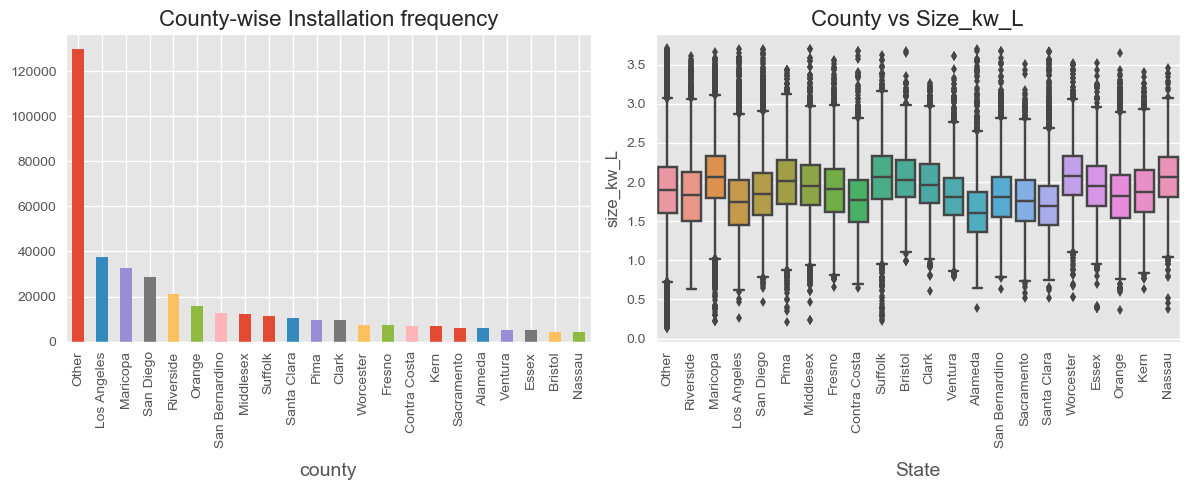

In [478]:
f,ax = plt.subplots(1,2,figsize=(12,5))

value_count_plot(data=solar, col='county', sort=True, ascending=False, ax=ax[0], 
                 xlabel='county', title='County-wise Installation frequency', size= 16, fontsize=10, font=14, rotation=90)


cat_box_plot(x= 'county', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='County vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>
    
→ Counties that have contributed less than 1% of solar panel installation are aggregated as `others`

→ LA and Maricopa have installed maximum number of solar panels <br>

→ Although solar panel has been popular in centain counties from early days such as LA, SanDiego, Sanat Clara (basically CA), 
overall adoption has increased since 2004-2005 in various other counties

## `incentive_prog_names`: incentive programs for solar panel installation

In [479]:
pd.options.display.max_columns = 25
incentive_prog_names = solar.groupby('incentive_prog_names').agg({'size_kw':['mean', 'median', 'size']})
incentive_prog_names.columns = ['size_mean', 'size_median', 'size_number']
incentive_prog_names.sort_values(by='size_number', ascending=False).style.apply(highlight_max)

,size_mean,size_median,size_number
incentive_prog_names,,,
California Public Utilities Commission (California Solar Initiative),5.77564,5.17,112646
California Public Utilities Commission (Non-CSI Net Metered Systems),5.58979,5.1238,62263
New York State Energy Research and Development Authority,7.44831,7,32043
Arizona Public Service,7.16509,6.72,27580
Massachusetts Clean Energy Center,6.59574,6,26504
Massachusetts Department of Energy Resources,7.11481,6.5,18249
Other,5.62124,5.13,15636
Los Angeles Department of Water & Power,5.42173,4.8,14134
California Energy Commission (New Solar Homes Partnership),3.19517,2.4,13372


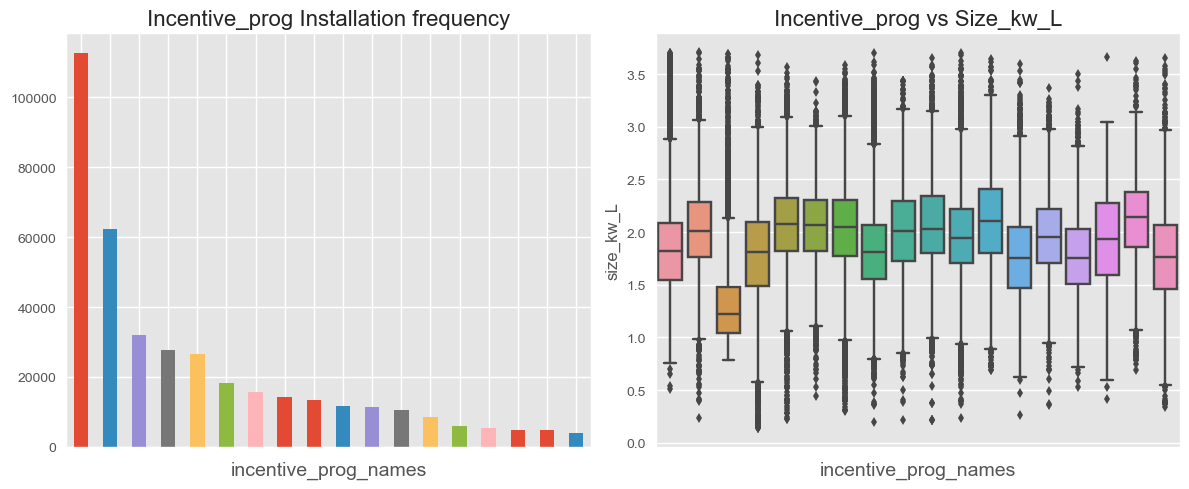

In [481]:
f,ax = plt.subplots(1,2,figsize=(12,5))
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)

value_count_plot(data=solar, col='incentive_prog_names', sort=True, ascending=False, ax=ax[0], 
                 xlabel='incentive_prog_names', title='Incentive_prog Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'incentive_prog_names', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='incentive_prog_names', 
                     title='Incentive_prog vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>
    
→ Similar to counties, any incentive program that have been used in less than 1% of solar panel installations are aggregated as `others`

→ Most active incentive programs are in CA, as CA was one of the early adopters of clean energy or solar panels 

## `city`: city of installation

In [486]:
solar.groupby('city').agg({'annual_PV_prod':['mean', 'median', 'size']}).style.apply(highlight_max)

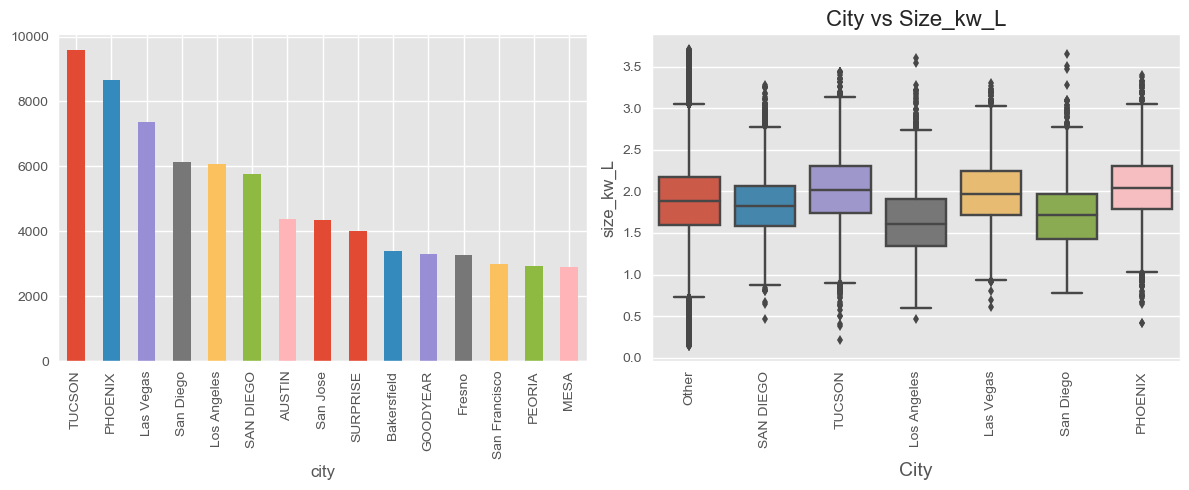

In [485]:
f,ax = plt.subplots(1,2,figsize=(12,5))

solar_x_city = solar_x.groupby('city').agg({'size_kw':['mean', 'median', 'size']})
solar_x_city.columns = ['size_mean', 'size_median', 'total']
solar_x_city = solar_x_city.sort_values(by = 'total', ascending=False)
solar_x_city = solar_x_city.iloc[:15]
solar_x_city['total'].plot(kind='bar', ax=ax[0])

cat_box_plot(x= 'city', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='City', 
                     title='City vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

Text(0.5,1,'City vs Annual Solar Energy Production')

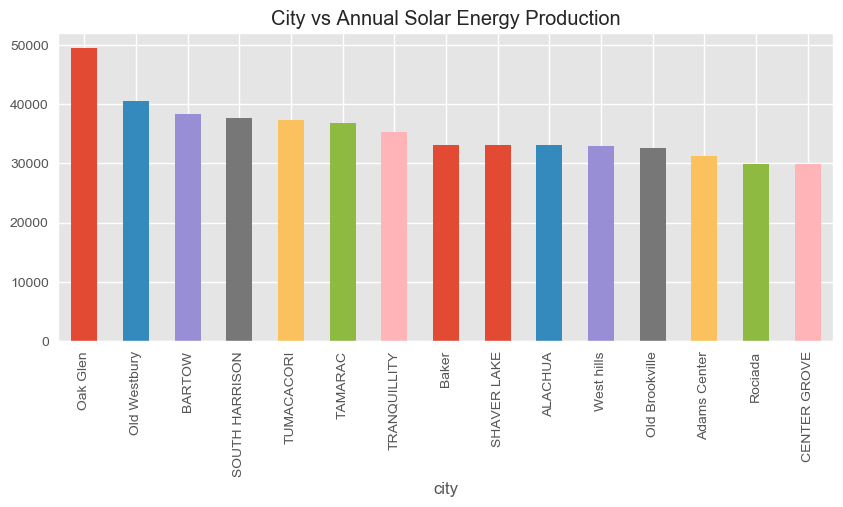

In [488]:
f,ax = plt.subplots(figsize=(10,4))
solar_x_city = solar_x.groupby('city').agg({'annual_PV_prod':['mean', 'median', 'size']})
solar_x_city.columns = ['size_mean', 'size_median', 'total']
solar_x_city = solar_x_city.sort_values(by = 'size_mean', ascending=False)
solar_x_city = solar_x_city.iloc[:15]
solar_x_city['size_mean'].plot(kind='bar')
ax.set_title('City vs Annual Solar Energy Production')

♦ **Initial observation:** <br>
    
→ Similar to counties, any city that had installed less than 1% of solar panel are aggregated as `others`

→ Phoenix city has installed solar panels with highest `size_kw`

→ Number of installations are highest in Arizona and CA

→ Cities with maximum solar panel installations does NOT mean they produce maximum solar energy. This could be for various factors. Cities can install more solar panels but with relatively smaller sizes. Or cities with less insolation will produce less solar energy w.r.t. to the city that get more insolation even if they have similar installations

## `Tracking type`: impacts the efficiency of solar energy production

In [489]:
solar.groupby('tracking_type').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

In [490]:
solar.groupby('tracking_type').agg({'annual_PV_prod':['mean', 'median', 'size']}).style.apply(highlight_max)

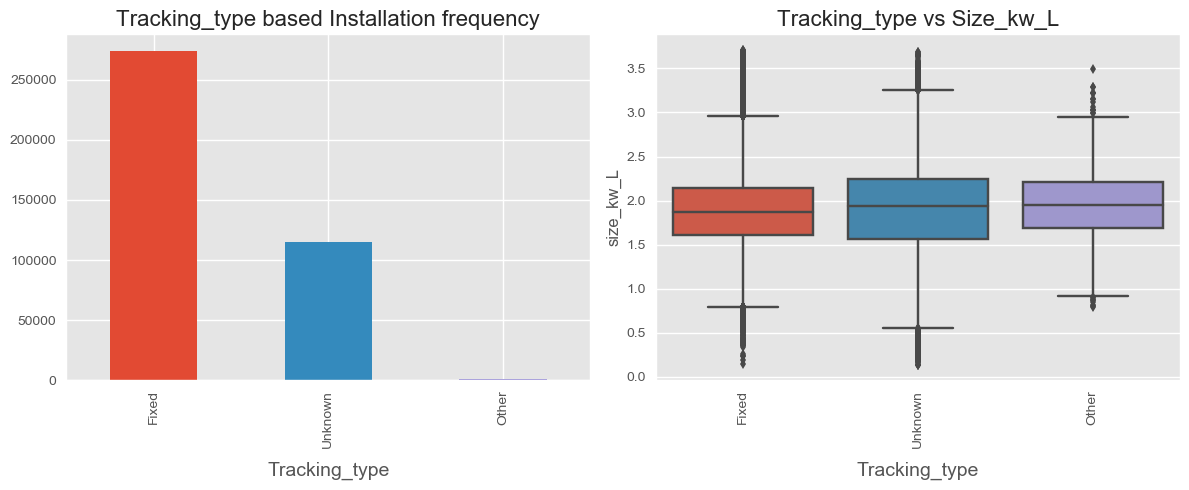

In [492]:
f,ax = plt.subplots(1,2,figsize=(12,5))

value_count_plot(data=solar, col='tracking_type', sort=True, ascending=False, ax=ax[0], 
                 xlabel='Tracking_type', title='Tracking_type based Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'tracking_type', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='Tracking_type', 
                     title='Tracking_type vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>
    
→ Most popular `tracking system` is fixed

→ Overall, `tracking system` does not seem related with size_kw

# Outlier detection

In [77]:
from collections import Counter
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 2 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )  
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(solar,2,['size_kw', 'annual_PV_prod', 'annual_insolation'])
solar.loc[Outliers_to_drop]

,state,date_installed,incentive_prog_names,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod,annual_insolation,tracking_type,zipcode_1,zipcode_2,zipcode_3,year,month


# 2.B. Converting String Values into Numeric

Since we cannot pass strings to a machine learning model, we need to convert features like glucose group. diastolic group into numeric values.

In [78]:
# Converting features into suitable form for modeling
solar1 = pd.get_dummies(solar)

In [79]:
solar1.shape

(389802, 89)

# 3. Predictive Modeling